CE888 - Lab3 - Predictive Modelling

In [1]:
import pandas as pd

df = pd.read_csv("./bank-additional-full.csv", delimiter = ";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [2]:
df_dummies = pd.get_dummies(df)
df_dummies.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,0,0,1,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,0,0,1,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,0,0,1,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,0,0,1,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,0,0,1,0,1,0


NOTE ordinate fields (that did not require any conversion) are now shown first, followed by categoric fields that required conversion.
The following 2 fields are now deleted, for the reasons stated below :
    Duration - is not known prior to the call, so it is not a predictor (rather, it is also an outcome - albeit one we are not trying to predict, hence it is not relevant)
    y_no - is redundant as it is equivalent to  y_yes == 0.  Put another way, y_yes[0/1] alone encapsulates the outcome we are trying to predict

In [3]:
del df_dummies['duration']
del df_dummies['y_no']

In [5]:
df_dummies.shape

(41188, 63)

As can be seen, there are now 2 fewer columns, confirming deletion of these 2 fields 

(array([ 36548.,   4640.]),
 array([ 0. ,  0.5,  1. ]),
 <a list of 2 Patch objects>)

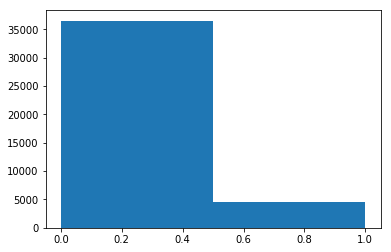

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.hist(df_dummies['y_yes'], bins=2)

As can be seen in the above plot, onlly 4640 (around 10%) of the 41188 samples have a positive result (ie. client subscribed to the term deposit)

Now prepare data for input into the predictor. A copy of the features is taken to preserve the data frame

In [8]:
df_dummies = df_dummies.dropna()
X = df_dummies.copy()
del X['y_yes'] #remove labels

# and convert to numpy arrays
X = X.values 
y = df_dummies['y_yes'].values

Classify.
Both cross-validated (10-fold) and full range predictions are performed
Randomised trees are used to reduce variance, and hopefully produce a better generalised model

In [11]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer

clf = ExtraTreesClassifier(n_estimators = 2000,max_depth = 4)
scores = cross_val_score(clf, X, y, cv=10, scoring = make_scorer(acc))
print("ACC 10-Kfold stratified CV: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
clf.fit(X, y)
print("ACC: %0.2f"% (acc(y,clf.predict(X)))) #equivalent to clf.score(X, y)

ACC 10-Kfold stratified CV: 0.85 (+/- 0.11)
ACC: 0.90


now print features importances.
as we have used one hot encoding (large feature space) only the top 14 features are shown - remainder are trivial 

In [14]:
import numpy as np

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(14):
    print("%d. %s (%f)" % (f + 1, df_dummies.columns[indices[f]],  importances[indices[f]]))

Feature ranking:
1. pdays (0.181249)
2. poutcome_success (0.154059)
3. nr.employed (0.142352)
4. euribor3m (0.121725)
5. emp.var.rate (0.091078)
6. poutcome_nonexistent (0.042768)
7. cons.conf.idx (0.034454)
8. month_mar (0.026632)
9. month_may (0.023947)
10. cons.price.idx (0.023453)
11. contact_telephone (0.020278)
12. month_oct (0.019757)
13. contact_cellular (0.019437)
14. poutcome_failure (0.015293)


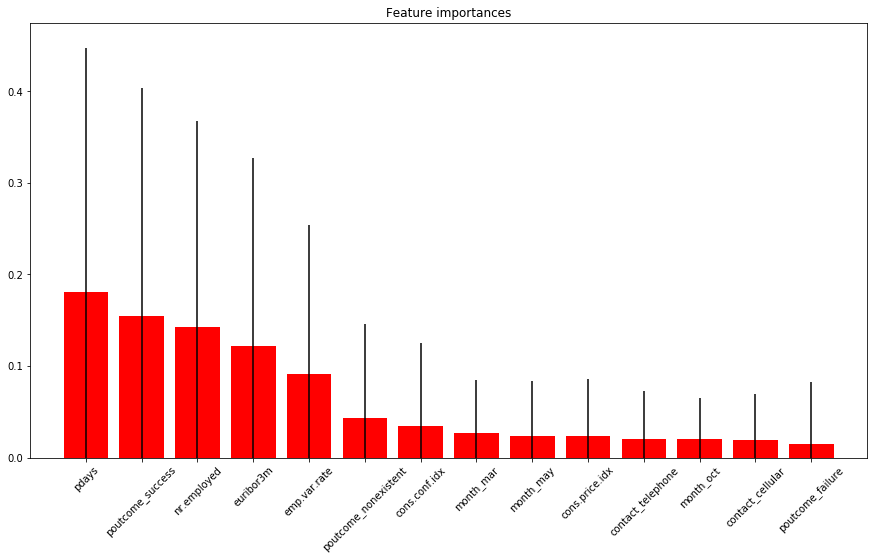

In [15]:
fig = plt.figure()
plt.title("Feature importances")
plt.bar(range(14), importances[indices[:14]], color="r", yerr=std[indices[:14]], align="center")
plt.xticks(range(14), df_dummies.columns[indices[:14]])
plt.xlim([-1, 14])
fig.set_size_inches(15,8)
axes = plt.gca()
axes.set_ylim([0,None])
axes.set_xticklabels(df_dummies.columns[indices[:14]], rotation=45)
plt.savefig("importances.png",bbox_inches='tight')
plt.savefig("importances.pdf",bbox_inches='tight')

Normalized confusion matrix


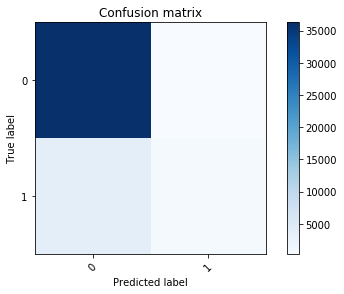

In [16]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        t = "(%.2f)"%(cm[i, j])
        #print t
#         plt.text(j, i, t,
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
y_pred = clf.predict(X)
cnf_matrix = confusion_matrix(y, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(len(set(y))), normalize = True,
                      title='Confusion matrix')

plt.savefig("confusion.png",bbox_inches='tight')
plt.savefig("confusion.pdf",bbox_inches='tight')